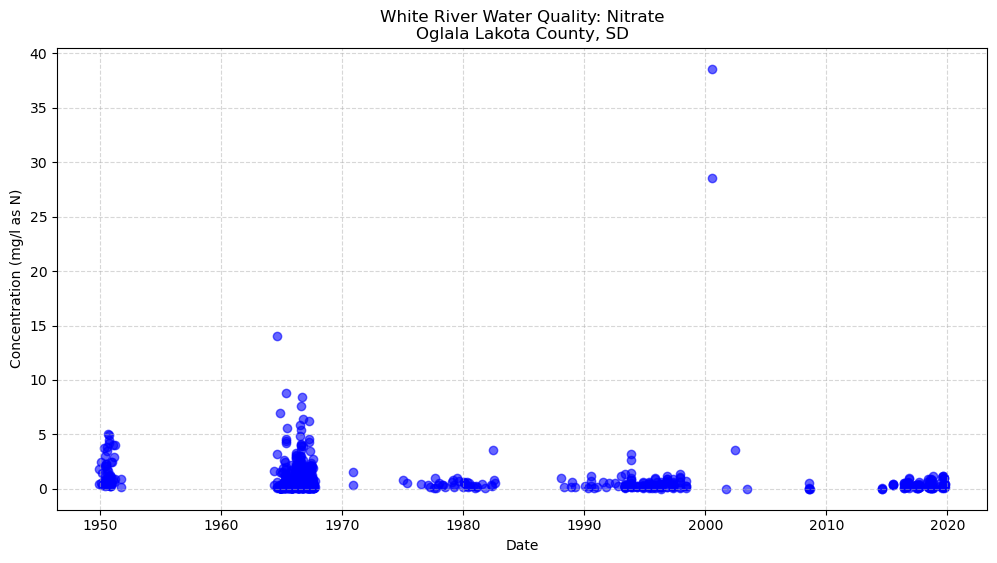

Success! Data saved to 'white_river_water_quality.csv'


In [7]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Define the parameters
params = {
    "countrycode": "US",
    "statecode": "US:46",
    "countycode": "US:46:102",
    "siteType": "Stream",
    "characteristicName": "Nitrate",
    "startDate": "2020-01-01",
    "endDate": "2023-12-31",
    "mimeType": "csv",  # Using CSV instead of JSON for more reliable parsing
}

# USGS Water Quality Portal API endpoint
url = "https://www.waterqualitydata.us/data/Result/search"

try:
    # Fetch data
    response = requests.get(url, params=params, timeout=30)
    response.raise_for_status()  # Raises an exception for 4XX/5XX errors
    
    # Check if response is empty
    if not response.content:
        raise ValueError("Empty response from server")
    
    # Try parsing as CSV
    df = pd.read_csv(StringIO(response.text))
    
    if not df.empty:
        # Clean and extract relevant columns
        columns_to_keep = [
            "MonitoringLocationIdentifier",
            "ActivityStartDate",
            "CharacteristicName",
            "ResultMeasureValue",
            "ResultMeasure/MeasureUnitCode"
        ]
        
        # Ensure columns exist
        available_columns = [col for col in columns_to_keep if col in df.columns]
        if not available_columns:
            raise ValueError("No expected columns found in response")
            
        df = df[available_columns].dropna()
        
        # Convert dates and numeric values
        df["ActivityStartDate"] = pd.to_datetime(df["ActivityStartDate"])
        df["ResultMeasureValue"] = pd.to_numeric(df["ResultMeasureValue"], errors="coerce")
        
        # Plot time-series
        plt.figure(figsize=(12, 6))
        plt.scatter(df["ActivityStartDate"], df["ResultMeasureValue"], color="blue", alpha=0.6)
        plt.title(f"White River Water Quality: {df['CharacteristicName'].iloc[0]}\nOglala Lakota County, SD")
        plt.xlabel("Date")
        plt.ylabel(f"Concentration ({df['ResultMeasure/MeasureUnitCode'].iloc[0]})")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
        
        # Save to CSV
        df.to_csv("white_river_water_quality.csv", index=False)
        print(f"Success! Data saved to 'white_river_water_quality.csv'")
    else:
        print("No water quality data found for the specified parameters.")

except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")
except pd.errors.EmptyDataError:
    print("Received empty data from the API")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [8]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('white_river_water_quality.csv')

# Display the first few rows to verify
print(df.head())

# Display basic information about the DataFrame
print(df.info())

# Display summary statistics for numerical columns
print(df.describe())

  MonitoringLocationIdentifier ActivityStartDate CharacteristicName  \
0                USGS-06446000        1950-04-11            Nitrate   
1                USGS-06446000        1950-04-11            Nitrate   
2                USGS-06446000        1950-08-15            Nitrate   
3                USGS-06446000        1950-08-15            Nitrate   
4                USGS-06446000        1950-07-17            Nitrate   

   ResultMeasureValue ResultMeasure/MeasureUnitCode  
0               0.836                     mg/l as N  
1               3.700                    mg/l asNO3  
2               0.361                     mg/l as N  
3               1.600                    mg/l asNO3  
4               0.316                     mg/l as N  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MonitoringLocationId

In [9]:


# Read the CSV file
df = pd.read_csv('white_river_water_quality.csv')

# Extract only the date and nitrate columns
nitrate_data = df[['ActivityStartDate', 'ResultMeasureValue']].copy()

# Rename columns for clarity
nitrate_data.columns = ['Date', 'Nitrate_Level']

# Convert Date to datetime format
nitrate_data['Date'] = pd.to_datetime(nitrate_data['Date'])

# Remove any rows with missing values
nitrate_data = nitrate_data.dropna()

# Display the cleaned data
print(nitrate_data.head())

# Optional: Save to new CSV
nitrate_data.to_csv('white_river_nitrate_levels.csv', index=False)

        Date  Nitrate_Level
0 1950-04-11          0.836
1 1950-04-11          3.700
2 1950-08-15          0.361
3 1950-08-15          1.600
4 1950-07-17          0.316


In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Read your water quality CSV
water_quality = pd.read_csv("white_river_water_quality.csv")

# Get unique station IDs from your data
station_ids = water_quality["MonitoringLocationIdentifier"].unique()
print(f"Found {len(station_ids)} monitoring stations")

# Fetch station locations from USGS
stations_url = "https://www.waterqualitydata.us/data/Station/search"
params = {
    "siteid": ",".join(station_ids),
    "mimeType": "csv"
}

response = requests.get(stations_url, params=params)
stations = pd.read_csv(StringIO(response.text))

# Convert to GeoDataFrame
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations.LongitudeMeasure, stations.LatitudeMeasure),
    crs="EPSG:4326"  # WGS84
)

Found 37 monitoring stations


Found 37 monitoring stations
Error occurred: aspect must be finite and positive 
Check your data structure and column names

Sample of your water quality data:
  MonitoringLocationIdentifier ActivityStartDate CharacteristicName  \
0                USGS-06446000        1950-04-11            Nitrate   
1                USGS-06446000        1950-04-11            Nitrate   
2                USGS-06446000        1950-08-15            Nitrate   
3                USGS-06446000        1950-08-15            Nitrate   
4                USGS-06446000        1950-07-17            Nitrate   

   ResultMeasureValue ResultMeasure/MeasureUnitCode  
0               0.836                     mg/l as N  
1               3.700                    mg/l asNO3  
2               0.361                     mg/l as N  
3               1.600                    mg/l asNO3  
4               0.316                     mg/l as N  

Sample of station data:
Empty DataFrame
Columns: [OrganizationIdentifier, OrganizationFo

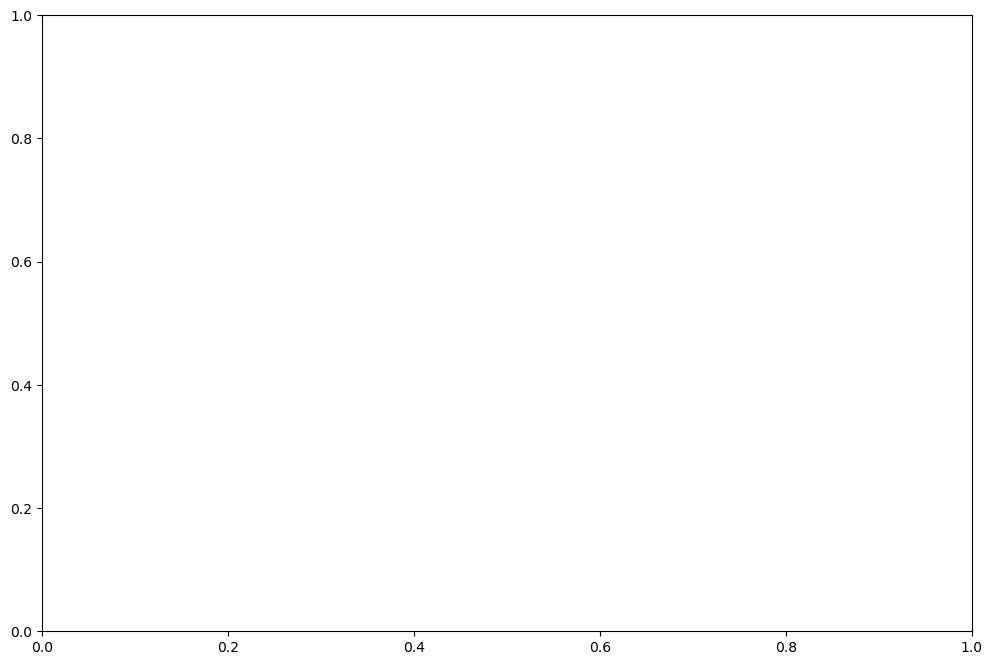

In [14]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO

# 1. Load and prepare the data
try:
    water_quality = pd.read_csv("white_river_water_quality.csv")
    
    # Get station IDs
    station_ids = water_quality["MonitoringLocationIdentifier"].unique()
    print(f"Found {len(station_ids)} monitoring stations")
    
    # Fetch station locations
    stations_url = "https://www.waterqualitydata.us/data/Station/search"
    params = {"siteid": ",".join(station_ids), "mimeType": "csv"}
    response = requests.get(stations_url, params=params)
    stations = pd.read_csv(StringIO(response.text))
    
    # Create GeoDataFrame
    gdf_stations = gpd.GeoDataFrame(
        stations,
        geometry=gpd.points_from_xy(stations.LongitudeMeasure, stations.LatitudeMeasure),
        crs="EPSG:4326"
    )

    # 2. Process nitrate data
    nitrate_data = water_quality[
        water_quality['CharacteristicName'].str.contains('nitrate', case=False, na=False)
    ].copy()
    
    # Convert to numeric and clean
    nitrate_data['ResultMeasureValue'] = pd.to_numeric(
        nitrate_data['ResultMeasureValue'], 
        errors='coerce'
    )
    nitrate_data = nitrate_data.dropna(subset=['ResultMeasureValue'])
    
    # Calculate averages
    avg_nitrate = nitrate_data.groupby('MonitoringLocationIdentifier')['ResultMeasureValue']\
                             .mean()\
                             .reset_index()\
                             .rename(columns={'ResultMeasureValue': 'AvgNitrate'})
    
    # 3. Merge and clean spatial data
    stations_with_nitrate = gdf_stations.merge(
        avg_nitrate,
        on='MonitoringLocationIdentifier',
        how='inner'  # Only keep stations with nitrate data
    )
    
    # 4. Create the visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Simple plot without legend_kwds first
    stations_with_nitrate.plot(
        column='AvgNitrate',
        cmap='YlOrRd',
        legend=True,
        ax=ax,
        markersize=100,
        edgecolor='black'
    )
    
    # Add basic map context if available
    try:
        import contextily as ctx
        ctx.add_basemap(ax, crs=gdf_stations.crs.to_string(), 
                       source=ctx.providers.OpenStreetMap.Mapnik)
    except:
        pass
    
    # Customize plot
    ax.set_title("White River Nitrate Concentrations", fontsize=14)
    ax.set_axis_off()
    
    # Add value labels
    for x, y, label in zip(
        stations_with_nitrate.geometry.x,
        stations_with_nitrate.geometry.y,
        stations_with_nitrate['AvgNitrate'].round(1)
    ):
        ax.text(x, y, str(label), fontsize=8, ha='left', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Save output
    fig.savefig('nitrate_map.png', dpi=300, bbox_inches='tight')
    print("Successfully created nitrate map")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("Check your data structure and column names")
    if 'water_quality' in locals():
        print("\nSample of your water quality data:")
        print(water_quality.head())
    if 'stations' in locals():
        print("\nSample of station data:")
        print(stations.head())

Loading data...
Water quality data loaded successfully
Columns: ['MonitoringLocationIdentifier', 'ActivityStartDate', 'CharacteristicName', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']

Processing nitrate data...

Fetching station locations...
Found 37 stations with nitrate data

Creating spatial data...

Creating visualization...
Adding basemap...

Saving output...
Map saved successfully as 'nitrate_map.png'


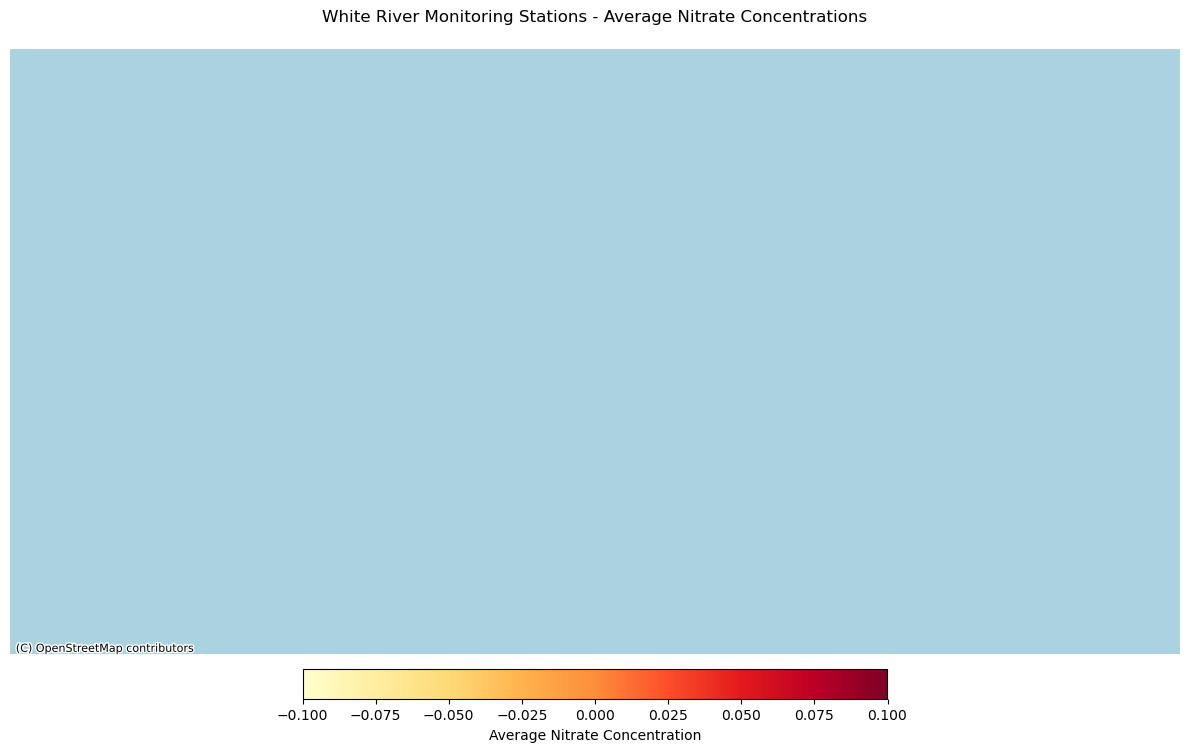

In [18]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
import numpy as np

# 1. Load and verify data
print("Loading data...")
try:
    water_quality = pd.read_csv("white_river_water_quality.csv")
    print("Water quality data loaded successfully")
    print(f"Columns: {water_quality.columns.tolist()}")
except Exception as e:
    print(f"Failed to load CSV: {str(e)}")
    raise

# 2. Process nitrate data
print("\nProcessing nitrate data...")
nitrate_mask = water_quality['CharacteristicName'].str.contains('nitrate', case=False, na=False)
nitrate_data = water_quality[nitrate_mask].copy()

if nitrate_data.empty:
    raise ValueError("No nitrate data found - check 'CharacteristicName' column")

# Clean numeric values
nitrate_data['ResultMeasureValue'] = pd.to_numeric(
    nitrate_data['ResultMeasureValue'], 
    errors='coerce'
)
nitrate_data = nitrate_data.dropna(subset=['ResultMeasureValue'])

# 3. Get station locations
print("\nFetching station locations...")
station_ids = nitrate_data["MonitoringLocationIdentifier"].unique()
print(f"Found {len(station_ids)} stations with nitrate data")

try:
    stations_url = "https://www.waterqualitydata.us/data/Station/search"
    params = {"siteid": ",".join(station_ids), "mimeType": "csv"}
    response = requests.get(stations_url, params=params)
    stations = pd.read_csv(StringIO(response.text))
except Exception as e:
    print(f"Failed to fetch stations: {str(e)}")
    raise

# 4. Create and merge geodataframes
print("\nCreating spatial data...")
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations.LongitudeMeasure, stations.LatitudeMeasure),
    crs="EPSG:4326"
)

avg_nitrate = nitrate_data.groupby('MonitoringLocationIdentifier')['ResultMeasureValue']\
                         .mean()\
                         .reset_index()\
                         .rename(columns={'ResultMeasureValue': 'AvgNitrate'})

gdf_nitrate = gdf_stations.merge(
    avg_nitrate,
    on='MonitoringLocationIdentifier',
    how='inner'
)

# 5. Create visualization with manual colorbar
print("\nCreating visualization...")
fig, ax = plt.subplots(figsize=(12, 8))

# Normalize nitrate values for coloring
vmin, vmax = gdf_nitrate['AvgNitrate'].min(), gdf_nitrate['AvgNitrate'].max()
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('YlOrRd')

# Plot each point individually with consistent sizing
for _, row in gdf_nitrate.iterrows():
    ax.scatter(
        x=row.geometry.x,
        y=row.geometry.y,
        c=[row['AvgNitrate']],
        cmap=cmap,
        norm=norm,
        s=100,
        edgecolor='black',
        linewidth=0.5
    )

# Add colorbar separately
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.5, pad=0.02)
cbar.set_label('Average Nitrate Concentration')

# Add value labels
for x, y, val in zip(gdf_nitrate.geometry.x, gdf_nitrate.geometry.y, gdf_nitrate['AvgNitrate']):
    ax.text(x, y, f"{val:.1f}", fontsize=8, ha='left', va='bottom')

# Add basemap if available
try:
    import contextily as ctx
    print("Adding basemap...")
    ctx.add_basemap(ax, crs=gdf_nitrate.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
except ImportError:
    print("Contextily not available - skipping basemap")

ax.set_title("White River Monitoring Stations - Average Nitrate Concentrations", pad=20)
ax.set_axis_off()
plt.tight_layout()

print("\nSaving output...")
fig.savefig('nitrate_map.png', dpi=300, bbox_inches='tight')
print("Map saved successfully as 'nitrate_map.png'")
plt.show()

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
import numpy as np

# 1. Load and verify data
print("Loading and verifying data...")
water_quality = pd.read_csv("white_river_water_quality.csv")

# Debug: Show available columns
print("\nWater quality columns:", water_quality.columns.tolist())

# 2. Process nitrate data
nitrate_data = water_quality[
    water_quality['CharacteristicName'].str.contains('nitrate', case=False, na=False)
].copy()

# Convert to numeric and clean
nitrate_data['ResultMeasureValue'] = pd.to_numeric(
    nitrate_data['ResultMeasureValue'], 
    errors='coerce'
)
nitrate_data = nitrate_data.dropna(subset=['ResultMeasureValue'])

# Debug: Show nitrate stats
print("\nNitrate values summary:")
print(nitrate_data['ResultMeasureValue'].describe())

# 3. Get station locations
station_ids = nitrate_data["MonitoringLocationIdentifier"].unique()
print(f"\nFound {len(station_ids)} stations with nitrate data")

response = requests.get

Loading and verifying data...

Water quality columns: ['MonitoringLocationIdentifier', 'ActivityStartDate', 'CharacteristicName', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']

Nitrate values summary:
count    780.000000
mean       0.841435
std        2.062475
min        0.000000
25%        0.160000
50%        0.343000
75%        0.824000
max       38.600000
Name: ResultMeasureValue, dtype: float64

Found 37 stations with nitrate data


In [6]:
import folium
import pandas as pd

# Create DataFrame with the manual gauge data
manual_gauges = pd.DataFrame([
    {"StationID": "06352000", "Name": "White River near Oglala", 
     "Latitude": 43.1833, "Longitude": -102.7336},
    {"StationID": "06353000", "Name": "White River near Crawford", 
     "Latitude": 42.6844, "Longitude": -103.4053}
])

# Calculate map center point
map_center = [manual_gauges['Latitude'].mean(), manual_gauges['Longitude'].mean()]

# Create the Folium map
m = folium.Map(
    location=map_center,
    zoom_start=9,
    tiles='OpenStreetMap',
    width='80%',
    height='60%'
)

# Add markers for each gauge
for index, row in manual_gauges.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"""
        <b>{row['Name']}</b><br>
        <b>USGS ID:</b> {row['StationID']}<br>
        <b>Latitude:</b> {row['Latitude']:.4f}<br>
        <b>Longitude:</b> {row['Longitude']:.4f}
        """,
        tooltip=f"Click for {row['Name']} details",
        icon=folium.Icon(
            color='blue',
            icon='tint',  # Water droplet icon
            prefix='fa'  # Font Awesome icon set
        )
    ).add_to(m)

# Add river name label
folium.Marker(
    location=[43.0, -103.0],  # Adjust position as needed
    icon=folium.DivIcon(
        html='<div style="font-size: 16pt; color: blue"><b>White River</b></div>'
    )
).add_to(m)

# Add measurement scale (new way)
folium.plugins.MeasureControl(position='bottomleft').add_to(m)

# Add minimap for navigation (new way)
folium.plugins.MiniMap().add_to(m)

# Display the map
display(m)

# Save to HTML file
m.save('white_river_gauges.html')
print("Map saved as 'white_river_gauges.html'")

AttributeError: module 'folium' has no attribute 'plugins'

In [1]:
import folium
print(folium.__version__)

0.19.7


In [2]:
import folium
from folium.plugins import MeasureControl, MiniMap, Fullscreen
import pandas as pd

# Create DataFrame with manual gauge data
manual_gauges = pd.DataFrame([
    {"StationID": "06352000", "Name": "White River near Oglala", 
     "Latitude": 43.1833, "Longitude": -102.7336},
    {"StationID": "06353000", "Name": "White River near Crawford", 
     "Latitude": 42.6844, "Longitude": -103.4053}
])

# Calculate map center point
center_lat = manual_gauges['Latitude'].mean()
center_lon = manual_gauges['Longitude'].mean()

# Create base map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=9,
    tiles='OpenStreetMap',
    control_scale=True
)

# Add markers for each gauge
for idx, row in manual_gauges.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"<b>{row['Name']}</b><br>"
              f"<b>Station ID:</b> {row['StationID']}<br>"
              f"<b>Latitude:</b> {row['Latitude']:.4f}<br>"
              f"<b>Longitude:</b> {row['Longitude']:.4f}",
        tooltip=row['Name'],
        icon=folium.Icon(color='blue', icon='tint', prefix='fa')
    ).add_to(m)

# Add river line (approximate White River path)
river_coords = [
    [43.1833, -102.7336],  # Oglala gauge
    [42.9, -103.0],         # Midpoint
    [42.6844, -103.4053]    # Crawford gauge
]

folium.PolyLine(
    locations=river_coords,
    color='blue',
    weight=3,
    opacity=0.7,
    tooltip="White River"
).add_to(m)

# Add measurement tools
MeasureControl(
    position='topright',
    primary_length_unit='miles'
).add_to(m)

# Add minimap for navigation
MiniMap().add_to(m)

# Add fullscreen button
Fullscreen().add_to(m)

# Display the map
display(m)

# Save to HTML file
m.save('white_river_gauges_map.html')
print("Map saved to 'white_river_gauges_map.html'")

Map saved to 'white_river_gauges_map.html'
